# Train a convolutional neural network

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Import libraries

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 19:35:11 2019

@author: hippolyte
"""

import os
import h5py
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
import imgaug as aug
import datetime
import pickle

from keras.applications import vgg16, vgg19, xception
from keras.models import Model, Sequential, load_model, save_model
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine import InputLayer

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

## Global variables

In [0]:
################################################################################
### MODIFIABLE VARIABLES
################################################################################
ROOT_PATH = 'drive/My Drive/master1/medical_image_recognition/'
DATASET_NAME = 'cancer_cells'
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg']

################################################################################
### DON'T CHANGE THESE VARIABLES
################################################################################
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH   = ROOT_PATH + 'arrays/'   + DATASET_NAME + '/'
MODEL_PATH   = ROOT_PATH + 'models/'   + DATASET_NAME + '/'
# create the directory to save arrays if it doesn't exist
#! mkdir -pv ARRAY_PATH, MODEL_PATH

# get directories and labels
DIRECTORIES = sorted([d for d in os.listdir(DATASET_PATH)])
LABELS = sorted(os.listdir(DATASET_PATH + DIRECTORIES[0]))
# helpers for labels
NUM_LABELS = len(LABELS)
LABEL_MAPPING = {label: code for code, label in enumerate(LABELS)}
# helper for paths
PATHS = {directory: DATASET_PATH + directory + '/' for directory in DIRECTORIES}

In [0]:
print(DIRECTORIES)
print(LABELS)
print(LABEL_MAPPING)

['test', 'train', 'val']
['cancer', 'normal']
{'cancer': 0, 'normal': 1}


## Fix seeds to have reproducible results

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [0]:
# the next instructions are used to make results reproducible
SEED = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.set_random_seed(SEED)
aug.seed(SEED)

## Data function

In [0]:
def label_code_to_str(label_code: int) -> str:
    """
    TODO
    """
    for label, code in LABEL_MAPPING.items():
        if label_code == code:
            return label

    raise ValueError('Couldn\'t find the code {} in labels'.format(label_code))

def get_data_dir(directory: str,
                 array_dir: str,
                 height: int=224,
                 width: int=224,
                 channels: int=3):
    """
    TODO
    """
    shape_str = '({},{},{})'.format(height, width, channels)
    filename = array_dir + directory + shape_str + '.h5'
    print('Getting {} images from {}'.format(shape_str, filename))
    
    # some helper variables
    start = datetime.datetime.now()
    
    with h5py.File(filename, 'r') as file:
        # assuming the file contains same amount of image and labels
        num_images = np.ceil(len(file.keys()) / 2).astype(int)

        # define arrays holding data and labels
        data = np.zeros((num_images, height, width, channels), dtype=np.float32)
        labels = np.zeros((num_images, NUM_LABELS), dtype=np.float32)

        # iterate over all images
        # format is x0 y0 for the first image and so on
        for image_index in range(num_images):
            image = file['x' + str(image_index)]
            label = file['y' + str(image_index)]

            data[image_index] = image
            labels[image_index] = label

    # shapes
    print('Data shape : {}\nLabels shape : {}'.format(data.shape, labels.shape))
    
    end = datetime.datetime.now()
    print('Found {} images in {} seconds.'.format(data.shape[0],
                                                 (end-start).seconds))
    
    return data, labels

## Convolutional Neural Network functions

### Create the network

In [0]:
def create_vgg19(include_top=True,
                 input_shape=(224, 224, 3),
                 frozen_layers=None):
    """
    TODO
    """
    # create the VGG model
    vgg19_model = vgg19.VGG19(include_top=include_top,
                              weights='imagenet',
                              input_shape=input_shape)
    # model name
    frozen_layers_str = '_'.join(frozen_layers) if frozen_layers else ''
    
    if include_top is True:
        # create a sequential model with corresponding name
        model_name = 'vgg19_' + frozen_layers_str
        model = Sequential(name=model_name)

        # add input layer at bottom
        model.add(InputLayer(input_shape=input_shape))

        # transform the vgg model into sequential
        # taking care to not add the last layer containing the dense layer
        for layer in vgg19_model.layers[:-1]:
            model.add(layer)

        # add last layer
        model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))
    
    else:
        # create a sequential model with corresponding name
        model_name = 'vgg19_custom_' + frozen_layers_str
        model = Sequential(name=model_name)
        
        # add input layer at bottom
        model.add(InputLayer(input_shape=input_shape))
        
        # add the vgg model to model
        for layer in vgg19_model.layers:
            model.add(layer)
        
        # add classification block
        model.add(Flatten(name='flatten'))
        model.add(Dense(1024, activation='relu', name='fc1')) #1024
        model.add(Dropout(0.7, name='dropout1'))              #notpresent
        model.add(Dense(512, activation='relu', name='fc2'))  #512
        model.add(Dropout(0.5, name='dropout2'))              #notpresent
        model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))
    
    ###################
    ### FREEZE PART ###
    ###################
    
    if frozen_layers is None:
        print('Everything is trainable.')
    
    else:
        # freeze the first 5 blocks
        if 'blocks' in frozen_layers:
            for i, layer in enumerate(model.layers):
                if layer.name not in ['fc1', 'fc2']:
                    layer.trainable = False

            print('Froze all blocks before classification one.')

        # freeze fc1
        if 'fc1' in frozen_layers:
            model.get_layer('fc1').trainable = False
            print('Froze fc1.')

        # freeze fc2
        if 'fc2' in frozen_layers:
            model.get_layer('fc2').trainable = False
            print('Froze fc2.')
    
    #####################
    ### COMPILE MODEL ###
    #####################
    
    loss_type = 'binary' if NUM_LABELS == 2 else 'categorical'
    loss_type += '_crossentropy'
    optimizer = Adam(lr=1e-6, decay=1e-5)
    
    model.compile(loss=loss_type,
                  metrics=['accuracy'],
                  optimizer=optimizer)
        
    return model

### Training function

In [0]:
def train_model(model,
                train_data,
                train_labels,
                val_data,
                val_labels,
                epoch=50,
                batch_size=32,
                metric='val_loss',
                save_best_only=True,
                save_model_path=None,
                save_weights_only=True,
                stop_after=5,
                save_history=True,
                save_history_path=None,
                class_weight_mapping=None):
    """
    TODO
    """
    # callbacks
    early_stopping = EarlyStopping(patience=stop_after,
                                   monitor=metric,
                                   restore_best_weights=True)
    
    checkpoint = ModelCheckpoint(save_model_path,
                                 monitor=metric,
                                 verbose=1,
                                 save_best_only=save_best_only,
                                 save_weights_only=save_weights_only)

    # here we are, we'll train the model
    history = model.fit(x=train_data,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1,
                        callbacks=[early_stopping, checkpoint],
                        validation_split=0.0,
                        validation_data=(val_data, val_labels),
                        shuffle=True,
                        class_weight=class_weight_mapping)

    # save history
    if save_history:
        with open(save_history_path, 'wb') as file:
            pickle.dump(history.history, file)
        print('\n\nSaved history into {}'.format(save_history_path))
    
    return model, history

### Plot results of the network

In [0]:
def plot_model_performance(model,
                           test_data,
                           test_labels,
                           batch_size=16):
    """
    TODO
    """
    print('Performances for {} model.'.format(model.name))
    print('\n\n')
    test_loss, test_score = model.evaluate(test_data,
                                           test_labels,
                                           batch_size=16)
    print('Loss : {}'.format(test_loss))
    print('Score : {}'.format(test_score))
    print('\n\n')

    # predictions and groud truth
    preds = model.predict(test_data, batch_size=batch_size)
    preds = np.argmax(preds, axis=-1)
    ground_truth = np.argmax(test_labels, axis=-1)
    
    # confusion matrix
    cm  = confusion_matrix(ground_truth, preds)
    
    # metrics
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    accuracy = np.diag(cm) / np.sum(cm)

    print('Recall : {}'.format(recall))
    print('Precision : {}'.format(precision))
    print('Accuracy : {}'.format(accuracy))
    print('\n\n')

    # plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm,
                          figsize=(12, 8),
                          hide_ticks=True,
                          cmap=plt.cm.Blues)
    plt.xticks(range(NUM_LABELS), LABELS) #, fontsize=16)
    plt.yticks(range(NUM_LABELS), LABELS) #, fontsize=16)
    plt.show()
    
    return preds
    
def plot_model_history(history_path):
    """
    TODO
    """
    print('Loading history from {}'.format(history_path))
    history = pickle.load(open(history_path, 'rb'))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) #, constrained_layout=True)

    # accuracy
    axes[0].plot(history['acc'])
    axes[0].plot(history['val_acc'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['train', 'val'])

    # loss
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['train', 'val'])
    plt.show()

## Let's do it !

### Data part

Getting (224,224,3) images from drive/My Drive/master1/medical_image_recognition/arrays/cancer_cells/test(224,224,3).h5
Data shape : (51, 224, 224, 3)
Labels shape : (51, 2)
Found 51 images in 0 seconds.
0(cancer)


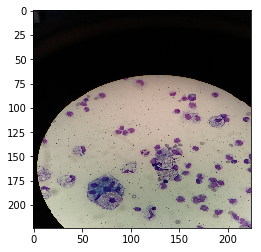

Getting (224,224,3) images from drive/My Drive/master1/medical_image_recognition/arrays/cancer_cells/train(224,224,3).h5
Data shape : (145, 224, 224, 3)
Labels shape : (145, 2)
Found 145 images in 1 seconds.
1(normal)


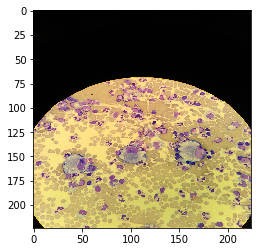

Getting (224,224,3) images from drive/My Drive/master1/medical_image_recognition/arrays/cancer_cells/val(224,224,3).h5
Data shape : (48, 224, 224, 3)
Labels shape : (48, 2)
Found 48 images in 0 seconds.
1(normal)


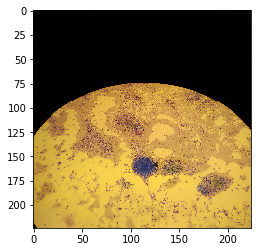

In [0]:
HEIGHT, WIDTH, CHANNELS = 224, 224, 3

data, labels = dict(), dict()

for directory in DIRECTORIES:
    # get data and labels
    data[directory], labels[directory] = get_data_dir(directory,
                                                      array_dir=ARRAY_PATH,
                                                      height=HEIGHT,
                                                      width=WIDTH,
                                                      channels=CHANNELS)
    
    # get a random index
    ind = np.random.randint(data[directory].shape[0])

    # plot the image with label
    plt.imshow(data[directory][ind])
    img_label = np.argmax(labels[directory][ind])
    img_label_str = label_code_to_str(img_label)
    #plt.title(img_label_str, img_label)
    print('{}({})'.format(img_label, img_label_str))
    plt.show()

### CNN creation

In [0]:
model = create_vgg19(include_top=True,
                     input_shape=(HEIGHT, WIDTH, CHANNELS),
                     frozen_layers=None)

model.summary()

Everything is trainable.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

### CNN training
#### USE IT WITH CAUTION, IT CAN TAKE TIME

In [0]:
import pandas as pd
df = pd.DataFrame(labels['train'])
d = dict(df[0].value_counts())
print(d)
#print(d[0] / d[1])

#LABEL_WEIGHTS = class_weight.compute_class_weight('balanced', =d)
#print(LABEL_WEIGHTS)

{0.0: 73, 1.0: 72}


In [0]:
CLASS_WEIGHT_MAPPING = None #{0: 1, 1: 0.35}

In [0]:
SAVE_MODEL_PATH = MODEL_PATH + model.name + '_model.hdf5'
SAVE_HISTORY_PATH = MODEL_PATH + model.name + '_history'

model, history = train_model(model,
                             train_data=data['train'],
                             train_labels=labels['train'],
                             val_data=data['val'],
                             val_labels=labels['val'],
                             epoch=200,
                             batch_size=32,
                             metric='val_acc',
                             save_best_only=True,
                             save_model_path=SAVE_MODEL_PATH,
                             save_weights_only=False,
                             stop_after=100,
                             save_history=True,
                             save_history_path=SAVE_HISTORY_PATH,
                             class_weight_mapping=CLASS_WEIGHT_MAPPING)

Train on 145 samples, validate on 48 samples
Epoch 1/200
145/145 [==============================] - 15s 104ms/step - loss: 0.7174 - acc: 0.4759 - val_loss: 0.7053 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to drive/My Drive/master1/medical_image_recognition/models/cancer_cells/vgg19__model.hdf5
Epoch 2/200
145/145 [==============================] - 6s 42ms/step - loss: 0.6742 - acc: 0.5310 - val_loss: 0.6956 - val_acc: 0.5417

Epoch 00002: val_acc improved from 0.50000 to 0.54167, saving model to drive/My Drive/master1/medical_image_recognition/models/cancer_cells/vgg19__model.hdf5
Epoch 3/200
145/145 [==============================] - 6s 42ms/step - loss: 0.6577 - acc: 0.5655 - val_loss: 0.6702 - val_acc: 0.5833

Epoch 00003: val_acc improved from 0.54167 to 0.58333, saving model to drive/My Drive/master1/medical_image_recognition/models/cancer_cells/vgg19__model.hdf5
Epoch 4/200
145/145 [==============================] - 6s 43ms/step - loss: 0

In [2]:
preds = plot_model_performance(model,
                               test_data=data['test'],
                               test_labels=labels['test'],
                               batch_size=32)

from sklearn.metrics import classification_report
print(classification_report(labels['test'],
                            preds,
                            target_names=LABELS))

NameError: ignored

Loading history from drive/My Drive/master1/medical_image_recognition/models/cancer_cells/vgg19__history


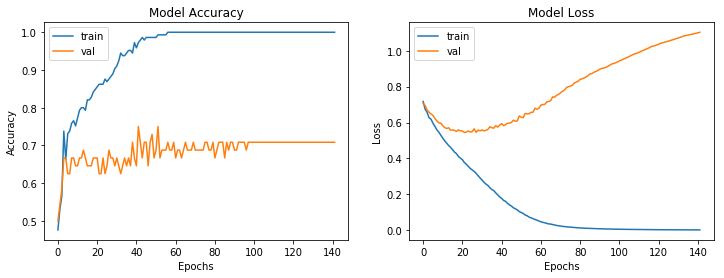

In [0]:
plot_model_history(SAVE_HISTORY_PATH)